In [1]:
#import importlib
#import Compute_evolution_of_clusters
#importlib.reload(Compute_evolution_of_clusters)
#from Compute_evolution_of_clusters import *
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
import tqdm

sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Analysis/')
sys.path.append('/home/hugo/PostDoc/aging_condensates/Gillespie/Analysis/')
from ToolBox import *

sys.path.append('/home/hcleroy/Extra_Module_py')
sys.path.append('/home/hugo/Extra_Module_py')
import formated_matplotlib

Ec = lambda L,N : 3/2*np.log(L/N* np.pi/3)

sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Gillespie_backend/')
sys.path.append('/home/hugo/PostDoc/aging_condensates/Gillespie/Gillespie_backend/')
import Gillespie_backend as gil


In [2]:
# gillespie parameter
Nlinker = 20
ell_tot = 10**3
V = 2*((ell_tot/6)**1.5/Nlinker**0.5*3/4*np.pi)
#kdiff = 100/(V) # for 3D
kdiff = 1.
Energy = -15
Nprocess = 10
args = [[ell_tot,Energy,kdiff,np.random.randint(1000000),Nlinker,3] for _ in range(Nprocess)]
print(Ec(ell_tot,Nlinker))
# Simulation parameters
step_tot = 200000
compute_steps = 10000
gillespie = gil.Gillespie(ell_tot=ell_tot, rho0=0., BindingEnergy=Energy, kdiff=kdiff,
                            seed=6542, sliding=False, Nlinker=Nlinker, old_gillespie=None, dimension=3)

5.937210903914155


def compute_MSD(gillespie,output,step_tot,check_steps,q_vector):
    msd_time = np.zeros((step_tot//check_steps,2),dtype=float)
    r_cumul = np.zeros(gillespie.N,dtype=float)  # the cumulated displacement of the particles
    initial_positions = gillespie.get_r()
    current_time = 0
    prev_position = gillespie.get_r()
    for n in range((step_tot//check_steps)):
        for t in range(check_steps):
            move,time = gillespie.evolve()
            current_time += np.sum(time)
            if move[0] == 1:
                dr = gillespie.get_r() - prev_position # vector of dimension N x 3
                prev_position = gillespie.get_r()

                part_cross_boundary = np.argwhere(np.linalg.norm(dr)>1)
                if np.linalg.norm(dr)>1.:
                    # reajust the value of dr
                    dr = 
                r_cumul+=dr
            msd_time[n] = [current_time, np.mean(dr**2)]
    return msd_time

In [56]:
def Follow_trajectory(gillespie,step_tot,periodic = False):
    trajectory = np.zeros((step_tot,gillespie.Nlinker,3),dtype=float)
    time = np.zeros(step_tot,dtype=float)
    for t in range(step_tot):
        trajectory[t] = gillespie.get_r(periodic)
        move,dt = gillespie.evolve()        
        if t>1:
            time[t] = time[t-1]+dt[0]
        else:
            time[t] =dt[0]
    return trajectory,time


In [57]:
trajectories,time = Follow_trajectory(gillespie,10000,True)

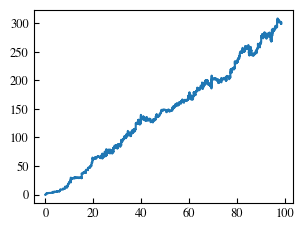

In [58]:
plt.plot(time,np.mean(np.linalg.norm(trajectories-trajectories[0],axis=2)**2,axis=1))
#plt.xlim(0,0.2*10**(-6))
#plt.ylim(-0.5,1)

In [92]:
def compute_MSD(gillespie,output,step_tot,check_steps,q_vector):        
    msd_time_list = list()
    for n in range((step_tot//check_steps)):
        current_time = 0
        #msd_time = np.zeros((step_tot//check_steps,2),dtype=float)
        initial_positions = gillespie.get_r(periodic = True)
        move,time = gillespie.evolve(check_steps)
        current_time += np.sum(time)
        msd_time = np.array([current_time, np.mean(np.linalg.norm(initial_positions - gillespie.get_r(periodic=True),axis=2)**2)])
        msd_time_list.append(msd_time)
    return msd_time_list
            

In [ ]:
MSD_t = compute_MSD(gillespie,None,10000,1000,None)

# ISF : intermediate scattering function

In [5]:
def uniform_sphere_samples(num_samples):
    """
    Generate uniformly distributed points on the surface of a unit sphere.
    :param num_samples: Number of points to generate.
    :return: Array of shape (num_samples, 3) representing points on a sphere.
    """
    phi = np.linspace(0, 2 * np.pi, num_samples)
    cos_theta = np.linspace(-1, 1, num_samples)
    theta = np.arccos(cos_theta)

    phi, theta = np.meshgrid(phi, theta)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    points = np.column_stack((x.ravel(), y.ravel(), z.ravel()))
    return points

def Compute_Average_ISF(current_positions, initial_positions, q_vectors):
    """
    Compute the direction-averaged ISF for a given q magnitude.
    :param current_positions: Current positions of particles (Nx3 array).
    :param initial_positions: Initial positions of particles (Nx3 array).
    :param q_magnitude: Magnitude of the wave vector q.
    :param num_q_samples: Number of q vector samples for averaging.
    """
    N = len(current_positions)
    displacement = current_positions - initial_positions  # Nx3 array of displacements

    # Calculate the exponential term for each q vector and displacement
    exp_terms = np.exp(1j * np.dot(displacement, q_vectors.T))  # Nxnum_q_samples array

    # Average over all particles and q vectors
    average_isf = np.mean(exp_terms, axis=(0, 1))
    return average_isf


In [6]:
# gillespie parameter
Nlinker = 20
ell_tot = 10**3
V = 2*((ell_tot/6)**1.5/Nlinker**0.5*3/4*np.pi)
#kdiff = 100/(V) # for 3D
kdiff = 1.
Energy = -15
Nprocess = 10
args = [[ell_tot,Energy,kdiff,np.random.randint(1000000),Nlinker,3] for _ in range(Nprocess)]
print(Ec(ell_tot,Nlinker))
# Simulation parameters
step_tot = 2000
compute_steps = 1
q_magnitude = np.arange(1,11,1)
num_q_samples = 100  # Number of q vector samples for averaging
gillespie = gil.Gillespie(ell_tot=ell_tot, rho0=0., BindingEnergy=Energy, kdiff=kdiff,
                            seed=6542, sliding=False, Nlinker=Nlinker, old_gillespie=None, dimension=3)

5.937210903914155


In [7]:
initial_positions = gillespie.get_r(periodic=True)
isf_data = np.zeros((q_magnitude.shape[0],step_tot//compute_steps,2),dtype=float)  # Dictionary to store time and ISF values
current_time = 0  # Keep track of total elapsed time

In [8]:
# Generate uniformly distributed q vectors
unit_q_vectors = uniform_sphere_samples(num_q_samples)
q_vectors = np.array([q * unit_q_vectors for q in q_magnitude])  # Scale to the desired magnitude

for step in tqdm.tqdm(range(step_tot//compute_steps)):
    time_interval, move = gillespie.evolve(compute_steps)
    current_time += np.sum(time_interval)
    for n,q_vector in enumerate(q_vectors):        
        isf_data[n,step] = [np.linalg.norm(Compute_Average_ISF(gillespie.get_r(periodic=True), initial_positions, q_vector)),current_time]

100%|██████████| 2000/2000 [09:32<00:00,  3.49it/s]


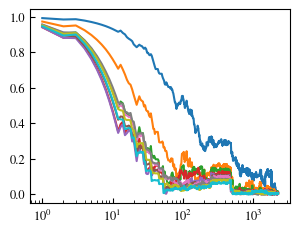

In [9]:
for isf in isf_data:
    plt.plot(isf[:,1],isf[:,0])
plt.xscale('log')

# Random walk model

In [85]:
import copy
def gillespie_walkers(N, L, tau_0, step_tot,compute_steps,q_norm,num_q_samples=10,confinement_size = 5):
    """
    Simulate N random walkers in a 3D box of size LxLxL using Gillespie algorithm.
    """
    def uniform_sphere_samples(num_samples):
        phi = np.linspace(0, 2 * np.pi, num_samples)
        cos_theta = np.linspace(-1, 1, num_samples)
        theta = np.arccos(cos_theta)
        phi, theta = np.meshgrid(phi, theta)
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        points = np.column_stack((x.ravel(), y.ravel(), z.ravel()))
        return points    
    # Function to perform a random step
    def random_step():
        phi = np.random.uniform(0, 2 * np.pi)
        cos_theta = np.random.uniform(-1, 1)
        theta = np.arccos(cos_theta)
        return np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
    def Compute_Average_ISF(displacement, q_vectors):
        # Calculate the exponential term for each q vector and displacement
        exp_terms = np.exp(1j * np.dot(displacement, q_vectors.T))  # Nxnum_q_samples array
        # Average over all particles and q vectors
        average_isf = np.mean(exp_terms, axis=(0, 1))
        return average_isf
    positions = np.random.uniform(0, L, (N, 3))  # Initial positions
    DeltaR = np.zeros((N,3),dtype=float)
    initial_positions = copy.copy(positions)
    #times = np.zeros(N)  # Times at which each walker will make its next jump
    ISF_MSD = np.zeros((step_tot//compute_steps,3),dtype=float)
    unit_q_vectors = uniform_sphere_samples(num_q_samples)
    q_vectors = q_norm * unit_q_vectors
    current_time = 0
    for step in range(step_tot):
        # Draw the time until the next jump for each walker
        time = np.random.exponential(tau_0/N, 1)[0]
        
        # Find the next jump
        walker_index = np.random.randint(0,N)
        # Update the position of the walker that jumps
        rand_step = random_step()
        pos = copy.copy(positions[walker_index])
        positions[walker_index] += rand_step
        if np.linalg.norm(positions[walker_index] - initial_positions[walker_index]) >= confinement_size: # simulate a slower diffusion at a larger scale
            positions[walker_index] -= rand_step*0.9 # remove 90% of the step

        positions[walker_index] %= L  # Apply periodic boundary conditions
        if np.linalg.norm(pos - positions[walker_index])  >1.1:
            DeltaR[walker_index] += positions[walker_index] - pos
            
        # Update the simulation time
        current_time += time
        if step%compute_steps==0:
            #raw_displacement = positions - initial_positions
            displacement = positions- DeltaR - initial_positions
            # Adjust displacements for periodic boundary conditions
            #displacement = raw_displacement - L * np.round(raw_displacement / L)
            ISF_MSD[step//compute_steps] = [current_time,np.linalg.norm(Compute_Average_ISF(displacement,q_vectors)),np.mean(np.linalg.norm(displacement,axis=1)**2)]
    return ISF_MSD

In [118]:
# Example parameters
N = 50  # Number of walkers
L = 500.0  # Box size
tau_0 = 1.0  # Characteristic time
step_tot = 100000
compute_steps = 100
# Simulate
RW_ISFs = np.zeros((3,step_tot//compute_steps,3),dtype=float)
for i,n in enumerate([0.1,0.25,0.5]):#enumerate(np.linspace(0.5,2,2)):
    RW_ISFs[i] = gillespie_walkers(N, L, tau_0, step_tot,compute_steps,n,confinement_size=5)


In [119]:
print(1/(0.1))
print((N/L**3)**(-1/3))
print("q optimal = " +str((N/L**3)**(1/3)*2*np.pi))

10.0
135.72088082974528
q optimal = 0.04629490516688815


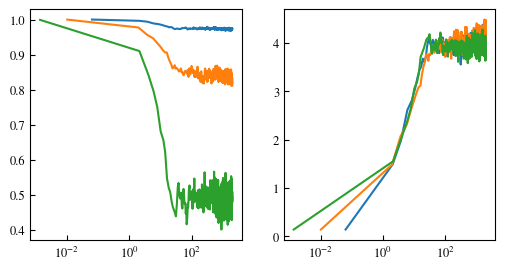

In [120]:
fig,ax = plt.subplots(ncols=2,figsize=(6,3))
for RW_ISF in RW_ISFs:
    ax[0].plot(RW_ISF[:,0],RW_ISF[:,1])
    ax[1].plot(RW_ISF[:,0],np.sqrt(RW_ISF[:,2]))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#plt.xlim(0,20)

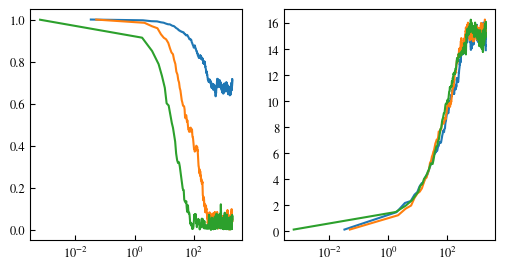

In [106]:
fig,ax = plt.subplots(ncols=2,figsize=(6,3))
for RW_ISF in RW_ISFs:
    ax[0].plot(RW_ISF[:,0],RW_ISF[:,1])
    ax[1].plot(RW_ISF[:,0],np.sqrt(RW_ISF[:,2]))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#plt.xlim(0,20)